In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# 设置超参数
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784      # MNIST 图片是 28x28 = 784
HIDDEN_DIM = 400     # 隐藏层维度
LATENT_DIM = 20      # 潜在空间维度，可以尝试调整
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3

In [2]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    # 将 28x28 的图片展平为 784 维的向量
    transforms.Lambda(lambda x: x.view(-1)) 
])

# 下载并加载训练数据
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 下载并加载测试数据
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 124kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]


- transforms.ToTensor()：格式标准化专家
这是 torchvision 中最基础、最重要的一个处理步骤。它负责把输入的图像转换成 PyTorch 张量，并且做了三件关键的事：

    - 类型转换：它将输入的 PIL Image 对象或者 numpy.ndarray 数组（数据类型通常是 uint8，即 0-255 的整数）转换成 torch.FloatTensor 类型。

    - 数值缩放 (Scaling)：它自动将图像中每个像素的数值从 [0, 255] 的范围，缩放到 [0.0, 1.0] 的范围。实现方式很简单，就是把每个像素值除以 255。这是神经网络训练中非常标准的操作，有助于模型稳定收敛。

    - 维度重排 (Dimension Reordering)：这一点非常重要！通常，图像数据在 NumPy 或 PIL 中表示为 H × W × C (高度 × 宽度 × 通道数)。而 PyTorch 的卷积层等模块期望的输入格式是 C × H × W (通道数 × 高度 × 宽度)。ToTensor() 会自动帮你完成这个维度顺序的调换。

In [4]:
import numpy as np 

print("--- 1. 原始输入 (NumPy 数组) ---")
o = np.random.randint(0, 256, size=(28, 28), dtype=np.uint8)
print(f'Type: {type(o)}\n Shape: {o.shape}\n Data_type: {o.dtype}')
# print(f'o: {o}')
print('-' * 30)

print("--- 2. 经过 ToTensor() 之后 ---")
to_tensor_transform = transforms.ToTensor()
tensor_image = to_tensor_transform(o)
print(f'Type: {type(tensor_image)}\n Shape: {tensor_image.shape}\n Data_type: {tensor_image.dtype}')
# print(f'Tensor_image: {tensor_image}')
print('-' * 30)

print("--- 3. 经过 Lambda(lambda x: x.view(-1)) 之后 ---")
flatten_transform = transforms.Lambda(lambda x: x.view(-1))
flattened_tensor = flatten_transform(tensor_image)
print(f'Type: {type(flattened_tensor)}\n Shape: {flattened_tensor.shape}\n Data_type: {flattened_tensor.dtype}')
# print(f'Tensor_image: {flattened_tensor}')
print('-' * 30)

--- 1. 原始输入 (NumPy 数组) ---
Type: <class 'numpy.ndarray'>
 Shape: (28, 28)
 Data_type: uint8
------------------------------
--- 2. 经过 ToTensor() 之后 ---
Type: <class 'torch.Tensor'>
 Shape: torch.Size([1, 28, 28])
 Data_type: torch.float32
------------------------------
--- 3. 经过 Lambda(lambda x: x.view(-1)) 之后 ---
Type: <class 'torch.Tensor'>
 Shape: torch.Size([784])
 Data_type: torch.float32
------------------------------


- 彩色图像有3通道  Red, Green, Blue(RGB三通道)
    - 在numpy中被表示成一个三维数组 H * W * C 例如(1920, 1080, 3) 对应R,G,B三通道
    - (1920, 1080, 3)经过ToTensor()后变成 C * H * W ，即(3, 1920, 1080)
- 而灰度图像 C=1  在numpy中一般表示成(28, 28, 1) -> (28, 28)

- HWC->CHW的原因是后者更方便进行卷积运算
    - 卷积操作的核心：卷积神经网络（CNN）的核心是卷积层。一个卷积核（Filter）本身也是一个小型的三维张量，它会在输入图像上滑动，并进行大量的乘加运算。关键在于，一个卷积核在某个位置进行计算时，需要同时访问**该位置附近所有通道的数据**。
    - 内存的连续性：现代 CPU 和 GPU 在处理数据时，读取一块连续的内存速度极快，而如果需要在内存中“跳来跳去”地读取不连续的数据，速度就会慢很多。这叫作“数据局部性 (Data Locality)”原理

它们分别代表图像的三个维度：
- H (Height): 高度。指图像在垂直方向上的像素数量。
- W (Width): 宽度。指图像在水平方向上的像素数量。
- C (Channels): 通道。指图像的颜色通道或特征通道的数量。

你可以把一张数字图像想象成一个三维的“像素块”。H 和 W 构成了这个块的平面尺寸，而 C 是这个块的“深度”。

带透明度的彩色图像 (RGBA Image): C = 4。除了 R, G, B 三个颜色通道外，它还增加了一个 Alpha 通道，用于表示该像素的不透明度。PNG 图片格式就支持 RGBA

#### 方案1 手动实现

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # --- 编码器 (Encoder) ---
        # 它的作用是学习输入数据的概率分布，并输出其参数 mu 和 log_var
        self.fc1 = nn.Linear(INPUT_DIM, HIDDEN_DIM)
        # 输出均值 mu
        self.fc_mu = nn.Linear(HIDDEN_DIM, LATENT_DIM)
        # 输出 log(方差)，即 log_var。我们不直接输出标准差是为了保证其为正，且训练更稳定
        self.fc_log_var = nn.Linear(HIDDEN_DIM, LATENT_DIM)
        
        # --- 解码器 (Decoder) ---
        # 它的作用是根据从潜在空间采样的 z，重建出原始数据
        self.fc3 = nn.Linear(LATENT_DIM, HIDDEN_DIM)
        self.fc4 = nn.Linear(HIDDEN_DIM, INPUT_DIM)

    def encode(self, x):
        # 编码器的前向传播
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        # 这就是我们讨论过的“重参数化技巧”
        # 它是为了让模型能够进行反向传播
        std = torch.exp(0.5 * log_var)  # 计算标准差 sigma
        eps = torch.randn_like(std)     # 从标准正态分布 N(0, 1) 中采样噪声 epsilon
        
        # z = mu + sigma * epsilon
        return mu + std * eps

    def decode(self, z):
        # 解码器的前向传播
        h = F.relu(self.fc3(z))
        # 使用 Sigmoid 激活函数将输出压缩到 [0, 1] 区间，匹配输入的像素值范围
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        # VAE 整体的前向传播过程
        # 1. 编码
        mu, log_var = self.encode(x)
        # 2. 重参数化采样
        z = self.reparameterize(mu, log_var)
        # 3. 解码
        reconstructed_x = self.decode(z)
        
        return reconstructed_x, mu, log_var

In [6]:
def loss_function(reconstructed_x, x, mu, log_var):
    # 1. 重建损失 (Reconstruction Loss)
    # 使用二元交叉熵损失 (Binary Cross-Entropy)，衡量重建图像与原始图像的相似度
    # reduction='sum' 表示对一个批次内的所有像素点的损失进行求和
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    
    # 2. KL 散度损失 (KL Divergence Loss)
    # 这是 KL 散度部分的解析解，衡量潜在分布 q(z|x) 与先验分布 p(z)=N(0,1) 的差异
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

**问题**
1. 为什么计算BCE要用reduction='sum', 而不是'mean'?
2. KLD为什么这么运算？ 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)？

In [7]:
model = VAE().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("开始训练...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        
        # 前向传播
        reconstructed_batch, mu, log_var = model(data)
        
        # 计算损失
        loss = loss_function(reconstructed_batch, data, mu, log_var)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_dataset):.4f}')
print("训练完成！")

开始训练...
====> Epoch: 1 Average loss: 165.4978
====> Epoch: 2 Average loss: 121.3632
====> Epoch: 3 Average loss: 114.3993
====> Epoch: 4 Average loss: 111.4532
====> Epoch: 5 Average loss: 109.7458
====> Epoch: 6 Average loss: 108.5459
====> Epoch: 7 Average loss: 107.7947
====> Epoch: 8 Average loss: 107.1034
====> Epoch: 9 Average loss: 106.5833
====> Epoch: 10 Average loss: 106.2168
训练完成！


生成的样本已保存到 vae_samples.png


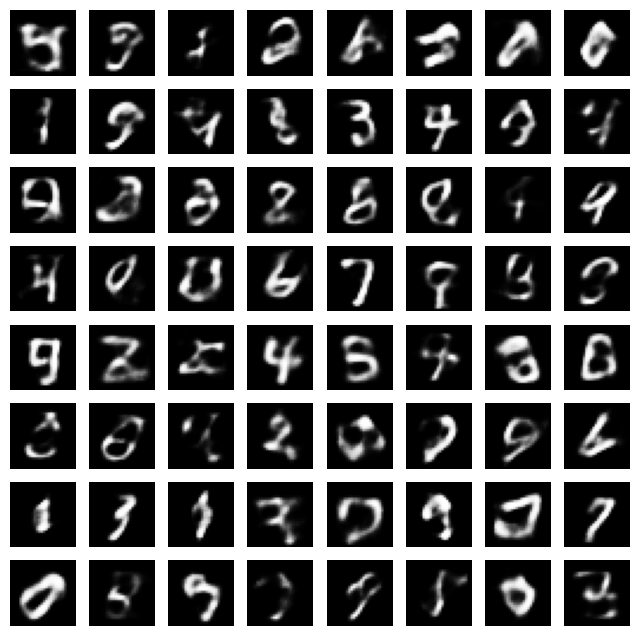

In [8]:
def generate_images(model, num_images=64):
    model.eval()
    with torch.no_grad():
        # 从标准正态分布 N(0, 1) 中随机采样 z
        # 这相当于从我们希望的先验分布 p(z) 中采样
        z = torch.randn(num_images, LATENT_DIM).to(DEVICE)
        
        # 仅使用解码器生成图像
        samples = model.decode(z).cpu()
        
        # 将生成的图像保存到文件
        save_image(samples.view(num_images, 1, 28, 28), 'vae_samples.png')
        print("生成的样本已保存到 vae_samples.png")

        # (可选) 使用 matplotlib 显示图像
        fig, axes = plt.subplots(8, 8, figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            ax.imshow(samples[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.show()

generate_images(model)